## Dependencies

In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost tqdm

## Libraries

In [13]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import xgboost as xgb
from tqdm import tqdm
import time


## Load and prepare the datasets

In [14]:
def load_transactions_data(file_path='transactions.json'):
    """Load transactions data from JSON file"""
    
    transactions = []
    with open(file_path, 'r') as f:
        for line in f:
            transactions.append(json.loads(line))
    
    # Convert to DataFrame
    df = pd.DataFrame(transactions)
    
    # Extract lat and long from location dictionary
    df['latitude'] = df['location'].apply(lambda x: x['lat'])
    df['longitude'] = df['location'].apply(lambda x: x['long'])
    df.drop('location', axis=1, inplace=True)
    
    return df

# Load merchants data
def load_merchants_data(file_path='merchants.csv'):
    """Load merchants data from CSV file"""
    return pd.read_csv(file_path)

# Load users data
def load_users_data(file_path='users.csv'):
    """Load users data from CSV file"""
    return pd.read_csv(file_path)

# Load all datasets
print("Loading transactions data...")
transactions_df = load_transactions_data()
print(f"Loaded {len(transactions_df)} transactions")

print("Loading merchants data...")
merchants_df = load_merchants_data()
print(f"Loaded {len(merchants_df)} merchants")

print("Loading users data...")
users_df = load_users_data()
print(f"Loaded {len(users_df)} users")

Loading transactions data...
Loaded 500000 transactions
Loading merchants data...
Loaded 1000 merchants
Loading users data...
Loaded 20000 users


## Data Exploration - Transactions Data

Transactions data sample:
  transaction_id            timestamp user_id merchant_id  amount   channel  \
0       TX000000  2022-06-17T23:28:00  U14804       M0314  130.03  in-store   
1       TX000001  2022-01-04T15:39:00  U16634       M0675  132.00    online   
2       TX000002  2022-09-09T21:58:00  U18005       M0479    8.65    online   
3       TX000003  2023-11-20T06:40:00  U13690       M0538   19.82    mobile   
4       TX000004  2022-04-28T08:08:00  U04642       M0128  101.92  in-store   

  currency   device payment_method  is_international  session_length_seconds  \
0      EUR  Android     debit_card                 1                     145   
1      EUR  Android     debit_card                 1                      32   
2      EUR  Android    credit_card                 1                     604   
3      EUR      iOS    credit_card                 0                    1031   
4      EUR  Android    credit_card                 1                     330   

   is_first_time_m

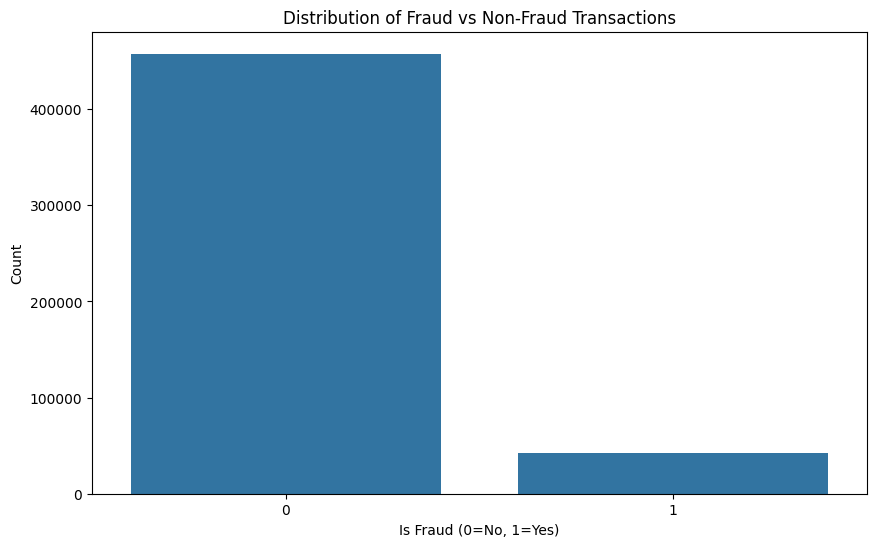

In [15]:
print("Transactions data sample:")
print(transactions_df.head())
print("\nTransactions data info:")
print(transactions_df.info())
print("\nTransactions data summary statistics:")
print(transactions_df.describe())

# Check for missing values
print("\nMissing values in transactions data:")
print(transactions_df.isnull().sum())

# Check fraud distribution
print("\nFraud distribution:")
fraud_dist = transactions_df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_dist)

# Visualize fraud distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='is_fraud', data=transactions_df)
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()


## Data Exploration - Users and Merchants

Users data sample:
  user_id  age     sex    education primary_source_of_income  \
0  U00001   56   Other  High School               Employment   
1  U00002   36  Female     Bachelor                 Business   
2  U00003   70   Other  High School              Student Aid   
3  U00004   38   Other  High School                  Savings   
4  U00005   61    Male  High School               Employment   

   sum_of_monthly_installments  sum_of_monthly_expenses  country signup_date  \
0                       477.69                   243.18  Finland  2021-04-01   
1                        31.60                   737.76   France  2020-07-07   
2                       275.72                  1477.50  Finland  2022-08-23   
3                       288.29                  1135.03  Belgium  2022-05-21   
4                         7.00                   892.76    Italy  2022-03-15   

   risk_score  
0    0.571079  
1    0.705268  
2    0.429579  
3    0.581384  
4    0.420227  

Merchants data sam

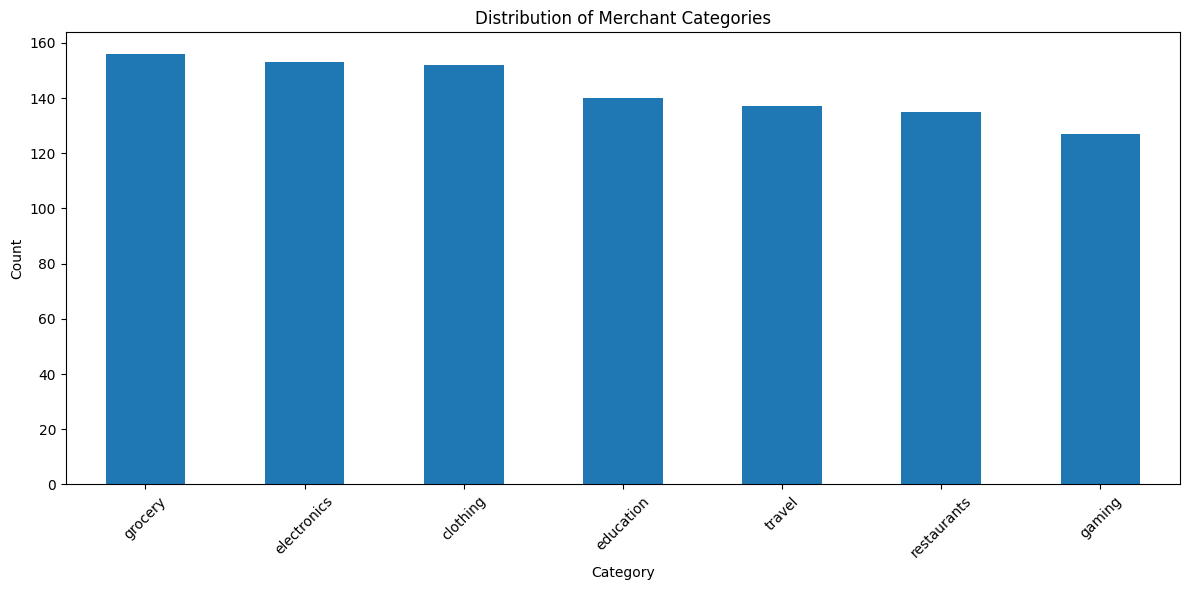

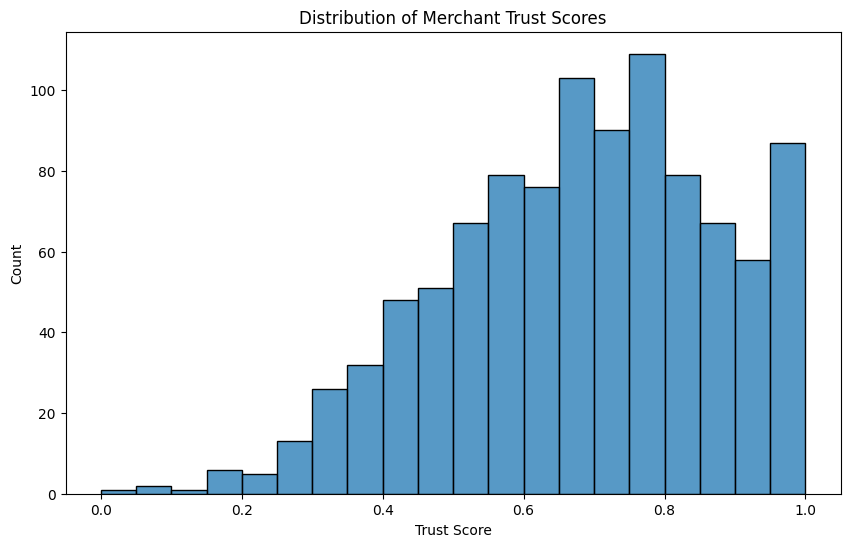

In [16]:
print("Users data sample:")
print(users_df.head())

print("\nMerchants data sample:")
print(merchants_df.head())

# Check merchant categories distribution
plt.figure(figsize=(12, 6))
merchants_df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Merchant Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check trust score distribution of merchants
plt.figure(figsize=(10, 6))
sns.histplot(merchants_df['trust_score'], bins=20)
plt.title('Distribution of Merchant Trust Scores')
plt.xlabel('Trust Score')
plt.ylabel('Count')
plt.show()


## Feature Engineering and Data Preprocessing

In [17]:

def merge_datasets(transactions, merchants, users):
    """Merge all datasets into a single DataFrame"""
    
    # Merge transactions with merchants
    # Specify suffixes to avoid column naming conflicts
    merged_df = pd.merge(transactions, merchants, on='merchant_id', how='left', suffixes=('', '_merchant'))
    
    # Merge with users
    # Specify suffixes to avoid column naming conflicts
    merged_df = pd.merge(merged_df, users, on='user_id', how='left', suffixes=('', '_user'))
    
    # Rename potentially conflicting columns to clear names
    column_mapping = {}
    for col in merged_df.columns:
        if col.endswith('_merchant') or col.endswith('_user'):
            # Keep only one version of conflicting columns, with a clear name
            base_col = col.replace('_merchant', '').replace('_user', '')
            if base_col + '_merchant' in merged_df.columns:
                column_mapping[base_col + '_merchant'] = 'merchant_' + base_col
            if base_col + '_user' in merged_df.columns:
                column_mapping[base_col + '_user'] = 'user_' + base_col
    
    # Apply the column renaming
    merged_df = merged_df.rename(columns=column_mapping)
    
    return merged_df

# Create new features
def create_features(df):
    """Create new features from existing data"""
    
    print("Creating features...")
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # More advanced time features
    df['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0)
    df['is_evening'] = df['hour'].apply(lambda x: 1 if (x >= 17 and x <= 21) else 0)
    df['is_morning'] = df['hour'].apply(lambda x: 1 if (x >= 6 and x <= 11) else 0)
    
    # Amount-based features
    print("Calculating amount-related features...")
    df['amount_to_avg_merchant'] = df['amount'] / df.groupby('merchant_id')['amount'].transform('mean')
    df['amount_to_avg_user'] = df['amount'] / df.groupby('user_id')['amount'].transform('mean')
    
    # Transaction recency and frequency features
    print("Calculating transaction frequency features...")
    # Group transactions by user
    df = df.sort_values(['user_id', 'timestamp'])
    
    # User transaction frequency
    df['user_transaction_count'] = df.groupby('user_id')['transaction_id'].transform('count')
    df['merchant_transaction_count'] = df.groupby('merchant_id')['transaction_id'].transform('count')
    df['user_merchant_count'] = df.groupby(['user_id', 'merchant_id'])['transaction_id'].transform('count')
    
    # Fraud-related features
    print("Computing risk-related features...")
    # Merchant risk score
    df['merchant_fraud_rate'] = df.groupby('merchant_id')['is_fraud'].transform('mean')
    
    # Amount deviation features
    df['user_amount_mean'] = df.groupby('user_id')['amount'].transform('mean')
    df['user_amount_std'] = df.groupby('user_id')['amount'].transform('std')
    df['user_amount_std'] = df['user_amount_std'].fillna(0)  # Handle users with only one transaction
    
    # Z-score of transaction amount for each user
    df['amount_zscore'] = (df['amount'] - df['user_amount_mean']) / df['user_amount_std'].replace(0, 1)
    
    # High value transaction flag
    df['high_value_transaction'] = (df['amount'] > df['user_amount_mean'] + 2 * df['user_amount_std']).astype(int)
    
    # Location-related features
    print("Computing location-related features...")
    # Calculate distance from user's typical location (mean lat/long)
    user_mean_lat = df.groupby('user_id')['latitude'].transform('mean')
    user_mean_long = df.groupby('user_id')['longitude'].transform('mean')
    
    # Simple Euclidean distance (not perfect for geo but good approximation for feature)
    df['distance_from_user_mean'] = np.sqrt(
        (df['latitude'] - user_mean_lat) ** 2 + 
        (df['longitude'] - user_mean_long) ** 2
    )
    
    # Unusual location flag
    df['unusual_location'] = (df['distance_from_user_mean'] > 
                             df.groupby('user_id')['distance_from_user_mean'].transform('mean') + 
                             2 * df.groupby('user_id')['distance_from_user_mean'].transform('std').fillna(0)).astype(int)
    
    # Session-based features
    df['long_session'] = (df['session_length_seconds'] > 
                          df.groupby('user_id')['session_length_seconds'].transform('mean') + 
                          df.groupby('user_id')['session_length_seconds'].transform('std').fillna(0)).astype(int)
    
    # Interaction features
    df['international_high_value'] = (df['is_international'] * df['high_value_transaction']).astype(int)
    df['unusual_location_high_value'] = (df['unusual_location'] * df['high_value_transaction']).astype(int)
    
    # Check if the 'merchant_is_first_time' column exists
    if 'merchant_is_first_time' in df.columns:
        df['first_time_merchant_high_value'] = (df['merchant_is_first_time'] * df['high_value_transaction']).astype(int)
    else:
        print("Warning: 'merchant_is_first_time' column not found, skipping related feature")
    
    print("Feature engineering complete.")
    return df

# Apply feature engineering
print("Merging datasets...")
full_df = merge_datasets(transactions_df, merchants_df, users_df)

# Debug: print column names after merging
print("\nColumns after merging datasets:")
print(full_df.columns.tolist())

print("Creating features...")
full_df = create_features(full_df)

# Handle missing values
print("Handling missing values...")
# First, fill missing values
for col in full_df.columns:
    if full_df[col].dtype == 'object':
        full_df[col] = full_df[col].fillna('Unknown')
    elif 'category' not in str(full_df[col].dtype):
        full_df[col] = full_df[col].fillna(full_df[col].median())

# Then, convert to category type
categorical_cols = [
    'channel', 'currency', 'device', 'payment_method', 'category',
    'country', 'merchant_country', 'user_country', 
    'sex', 'education', 'primary_source_of_income'
]
    
for col in categorical_cols:
    if col in full_df.columns:
        full_df[col] = full_df[col].astype('category')

# Prepare data for modeling
print("Preparing data for modeling...")

# Drop unnecessary columns
columns_to_drop = ['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'signup_date']
modeling_df = full_df.drop(columns=columns_to_drop)

# Convert categorical variables to dummy variables
cat_cols = modeling_df.select_dtypes(include=['category']).columns
modeling_df = pd.get_dummies(modeling_df, columns=cat_cols, drop_first=True)

# Ensure all columns are numeric
non_numeric_cols = modeling_df.select_dtypes(exclude=['number']).columns
if len(non_numeric_cols) > 0:
    print(f"Converting non-numeric columns: {non_numeric_cols}")
    for col in non_numeric_cols:
        # For any remaining string columns, try to convert to numeric or drop
        try:
            modeling_df[col] = pd.to_numeric(modeling_df[col], errors='coerce')
            # Fill NaN values created by coercion
            modeling_df[col] = modeling_df[col].fillna(modeling_df[col].median())
        except:
            print(f"Dropping column {col} as it cannot be converted to numeric")
            modeling_df = modeling_df.drop(columns=[col])

print(f"Final dataset shape: {modeling_df.shape}")


Merging datasets...

Columns after merging datasets:
['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount', 'channel', 'currency', 'device', 'payment_method', 'is_international', 'session_length_seconds', 'merchant_is_first_time', 'is_fraud', 'latitude', 'longitude', 'category', 'country', 'trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'age', 'sex', 'education', 'primary_source_of_income', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'user_country', 'signup_date', 'risk_score']
Creating features...
Creating features...
Calculating amount-related features...
Calculating transaction frequency features...
Computing risk-related features...
Computing location-related features...
Feature engineering complete.
Handling missing values...
Preparing data for modeling...
Converting non-numeric columns: Index(['channel_mobile', 'channel_online', 'device_Web', 'device_iOS',
       'payment_method_credi

## Train-Test Split

In [18]:
X = modeling_df.drop('is_fraud', axis=1)
y = modeling_df['is_fraud']

# Feature names for later use
feature_names = X.columns

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class imbalance
fraud_ratio = y_train.mean()
print(f"Fraud ratio in training data: {fraud_ratio:.4f} ({fraud_ratio*100:.2f}%)")
print(f"Class imbalance ratio: 1:{(1-fraud_ratio)/fraud_ratio:.1f}")


Training set: 400000 samples
Test set: 100000 samples
Fraud ratio in training data: 0.0848 (8.48%)
Class imbalance ratio: 1:10.8


## Handle Class Imbalance with Hybrid Approach

In [ ]:
print("Applying advanced sampling to balance the training data...")

# Use SMOTETomek, which combines SMOTE oversampling with Tomek links undersampling
# This helps to both oversample the minority class and clean the class boundary
sampler = SMOTETomek(random_state=42, sampling_strategy=0.4)
print("Running SMOTETomek to balance classes and clean decision boundary...")
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)

# Check new class distribution
balanced_fraud_ratio = y_train_balanced.mean()
print(f"Original samples: {len(X_train)}, Balanced samples: {len(X_train_balanced)}")
print(f"Fraud ratio after balancing: {balanced_fraud_ratio:.4f} ({balanced_fraud_ratio*100:.2f}%)")
print(f"New class ratio: 1:{(1-balanced_fraud_ratio)/balanced_fraud_ratio:.1f}")


Applying advanced sampling to balance the training data...
Running SMOTETomek to balance classes and clean decision boundary...


## Train XGBoost Model with Progress Display

In [9]:

print("Training XGBoost model with progress monitoring...")

# Scale features for better convergence
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Get class imbalance ratio for XGBoost scale_pos_weight parameter
imbalance_ratio = (1 - y_train.mean()) / y_train.mean()

# Define XGBoost parameters that work well for fraud detection
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,  # Learning rate
    'max_depth': 8,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': imbalance_ratio,  # Handle imbalance within the algorithm
    'tree_method': 'hist',  # For faster training
    'random_state': 42
}

print(f"XGBoost parameters: {xgb_params}")

# Convert data to DMatrix format for faster processing
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_balanced)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Set up evaluation list for progress monitoring
watchlist = [(dtrain, 'train'), (dtest, 'test')]

# Total number of boosting rounds
num_rounds = 300

# Train XGBoost with progress monitoring
print("Starting XGBoost training with progress monitoring...")
start_time = time.time()

# Training with early stopping to prevent overfitting
model = xgb.train(
    xgb_params,
    dtrain,
    num_rounds,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=20  # Print evaluation every 20 rounds
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")
print(f"Best iteration: {model.best_iteration}")
print(f"Best test AUC: {model.best_score:.4f}")


Training XGBoost model with progress monitoring...
Scaling features...
XGBoost parameters: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.05, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 10.789324766424004, 'tree_method': 'hist', 'random_state': 42}
Starting XGBoost training with progress monitoring...
[0]	train-auc:0.78227	test-auc:0.52907
[20]	train-auc:0.88836	test-auc:0.54231
[40]	train-auc:0.90021	test-auc:0.54693
[60]	train-auc:0.90422	test-auc:0.55019
[80]	train-auc:0.90657	test-auc:0.55341
[100]	train-auc:0.90815	test-auc:0.55566
[120]	train-auc:0.90947	test-auc:0.55742
[140]	train-auc:0.91088	test-auc:0.55931
[160]	train-auc:0.91322	test-auc:0.56073
[180]	train-auc:0.91580	test-auc:0.56160
[200]	train-auc:0.91835	test-auc:0.56262
[220]	train-auc:0.92090	test-auc:0.56291
[240]	train-auc:0.92342	test-auc:0.56251
[260]	train-auc:0.92605	test-auc:0.56242
[277]	train-auc:0.92904	test-auc:0.56253
Training comp

## Model Evaluation and Threshold Tuning

In [ ]:

print("\nEvaluating model on test data...")
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)  # Default threshold 0.5

# Calculate metrics with default threshold (0.5)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation metrics
print("Model Performance Metrics (default threshold):")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1_score: {f1:.4f}")
print(f"roc_auc: {auc:.4f}")

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report (default threshold):")
print(report_df)

# Threshold tuning
print("\nPerforming threshold tuning to optimize F1 score...")
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1 score for each threshold with detailed progress reporting
print(f"Testing {len(thresholds)} threshold values to find optimal F1 score...")
print("Each dot represents 5% of thresholds processed:")

f1_scores = []
total_thresholds = len(thresholds)
step_size = max(1, total_thresholds // 20)  # Report progress every ~5%
progress_counter = 0

for i, thresh in enumerate(tqdm(thresholds, desc="Finding optimal threshold")):
    # Calculate F1 score for this threshold
    current_pred = (y_pred_proba >= thresh).astype(int)
    current_f1 = f1_score(y_test, current_pred, zero_division=0)
    f1_scores.append(current_f1)
    
    # Report progress periodically
    if i % step_size == 0:
        progress_counter += 1
        if progress_counter % 4 == 0:  # every 20% report metrics
            fraud_detected = np.sum((y_pred_proba >= thresh) & (y_test == 1))
            total_fraud = np.sum(y_test == 1)
            print(f"\n  Threshold {thresh:.4f}: F1={current_f1:.4f}, detecting {fraud_detected}/{total_fraud} frauds ({fraud_detected/total_fraud*100:.1f}%)")

# Convert to numpy array for easier manipulation
f1_scores = np.array(f1_scores)

# Find the threshold that maximizes F1 score
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
max_f1 = f1_scores[optimal_threshold_idx]

print(f"\nOptimal threshold found: {optimal_threshold:.4f}")
print(f"Max F1 score: {max_f1:.4f}")

# Calculate and report additional metrics at optimal threshold
optimal_predictions = (y_pred_proba >= optimal_threshold).astype(int)
fraud_detected_optimal = np.sum((y_pred_proba >= optimal_threshold) & (y_test == 1))
total_fraud = np.sum(y_test == 1)
print(f"At optimal threshold: detecting {fraud_detected_optimal}/{total_fraud} frauds ({fraud_detected_optimal/total_fraud*100:.1f}%)")

# Apply the optimal threshold to make predictions
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculate metrics with optimal threshold
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal, zero_division=0)
recall_optimal = recall_score(y_test, y_pred_optimal, zero_division=0)
f1_optimal = f1_score(y_test, y_pred_optimal, zero_division=0)

print("\nModel Performance Metrics (optimal threshold):")
print(f"accuracy: {accuracy_optimal:.4f}")
print(f"precision: {precision_optimal:.4f}")
print(f"recall: {recall_optimal:.4f}")
print(f"f1_score: {f1_optimal:.4f}")
print(f"roc_auc: {auc:.4f}")  # AUC doesn't depend on threshold

# Generate classification report with optimal threshold
report_optimal = classification_report(y_test, y_pred_optimal, output_dict=True)
report_optimal_df = pd.DataFrame(report_optimal).transpose()
print("\nClassification Report (optimal threshold):")
print(report_optimal_df)



Evaluating model on test data...
Model Performance Metrics (default threshold):
accuracy: 0.5385
precision: 0.0986
recall: 0.5456
f1_score: 0.1671
roc_auc: 0.5624

Classification Report (default threshold):
              precision    recall  f1-score       support
0              0.927389  0.537850  0.680840   91518.00000
1              0.098630  0.545626  0.167061    8482.00000
accuracy       0.538510  0.538510  0.538510       0.53851
macro avg      0.513009  0.541738  0.423950  100000.00000
weighted avg   0.857093  0.538510  0.637261  100000.00000

Performing threshold tuning to optimize F1 score...
Testing 99224 threshold values to find optimal F1 score...
Each dot represents 5% of thresholds processed:


Finding optimal threshold:   7%|▋         | 7109/99224 [03:25<44:16, 34.67it/s]  


KeyboardInterrupt: 

## Cross-Validation and Hyperparameter Tuning

In [ ]:
param_space = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 6),
    'subsample': uniform(0.6, 0.3),
    'colsample_bytree': uniform(0.6, 0.3),
    'gamma': uniform(0, 0.5),
    'learning_rate': uniform(0.01, 0.14),
    'scale_pos_weight': uniform(1, 5)
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    tree_method='hist',
    random_state=42
)

# Setup cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create sampled datasets for faster tuning
from sklearn.utils import resample
# Use a smaller subset for tuning to speed up the process
sample_size = min(20000, len(X_train))
X_train_sample, y_train_sample = resample(
    X_train, y_train, 
    n_samples=sample_size,
    stratify=y_train,
    random_state=42
)

print(f"Using {sample_size} samples for hyperparameter tuning")

# Setup and run RandomizedSearchCV
print("Starting hyperparameter search with progress monitoring...")

# We'll use a custom CV approach with progress bars
from tqdm import tqdm
import numpy as np

# Number of iterations and CV folds
n_iter = 20
n_splits = 3
total_iterations = n_iter * n_splits

# Create parameter samples
from sklearn.model_selection import ParameterSampler
param_samples = list(ParameterSampler(param_space, n_iter=n_iter, random_state=42))

# Initialize results tracking
cv_results = {
    'params': [],
    'split_scores': [],
    'mean_score': [],
    'std_score': []
}

# Run cross-validation with progress bar
with tqdm(total=total_iterations, desc="Hyperparameter tuning") as pbar:
    # For each parameter combination
    for params in param_samples:
        split_scores = []
        
        # Setup cross-validation
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        # For each fold
        for train_idx, val_idx in kfold.split(X_train_sample, y_train_sample):
            # Get train/val split
            X_cv_train, y_cv_train = X_train_sample.iloc[train_idx], y_train_sample.iloc[train_idx]
            X_cv_val, y_cv_val = X_train_sample.iloc[val_idx], y_train_sample.iloc[val_idx]
            
            # Train model with these parameters
            cv_model = xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=100,
                tree_method='hist',
                random_state=42,
                **params
            )
            
            # Train
            cv_model.fit(X_cv_train, y_cv_train, 
                        eval_set=[(X_cv_val, y_cv_val)],
                        early_stopping_rounds=10,
                        verbose=0)
            
            # Evaluate and store score
            y_pred = cv_model.predict(X_cv_val)
            score = f1_score(y_cv_val, y_pred)
            split_scores.append(score)
            
            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({"Current F1": f"{score:.4f}"})
        
        # Store results for this parameter set
        cv_results['params'].append(params)
        cv_results['split_scores'].append(split_scores)
        cv_results['mean_score'].append(np.mean(split_scores))
        cv_results['std_score'].append(np.std(split_scores))

# Find best parameters
best_idx = np.argmax(cv_results['mean_score'])
best_params = cv_results['params'][best_idx]
best_score = cv_results['mean_score'][best_idx]

print("\nHyperparameter Optimization Results:")
print(f"Best Score: {best_score:.4f}")
print("Best Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Train the final model with best parameters
print("Training final model with optimized parameters...")

# Set required parameters
best_params['objective'] = 'binary:logistic'
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42

# Apply oversampling with the same strategy as before
print("Applying SMOTE-Tomek with optimal parameters...")
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

# Create DMatrix objects
dtrain_tuned = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
dtest_tuned = xgb.DMatrix(X_test, label=y_test)

# Create a progress callback for XGBoost
class TqdmCallback(object):
    def __init__(self, max_rounds=1000):
        self.pbar = tqdm(total=max_rounds, desc="Training optimized model")
        self.curr_round = 0
        self.best_score = 0
        self.best_round = 0
        
    def __call__(self, env):
        # Update progress bar
        new_round = env.iteration
        self.pbar.update(new_round - self.curr_round)
        self.curr_round = new_round
        
        # Track best score
        if len(env.evaluation_result_list) > 0:
            eval_result = env.evaluation_result_list[1][1]  # test-auc
            if eval_result > self.best_score:
                self.best_score = eval_result
                self.best_round = new_round
            self.pbar.set_postfix({"test-auc": f"{eval_result:.4f}", "best": f"{self.best_score:.4f}@{self.best_round}"})
    
    def close(self):
        self.pbar.close()

# Setup callback
tqdm_callback = TqdmCallback(max_rounds=1000)

# Train the final model with best parameters
best_model = xgb.train(
    best_params,
    dtrain_tuned,
    num_boost_round=1000,
    evals=[(dtrain_tuned, 'train'), (dtest_tuned, 'test')],
    early_stopping_rounds=50,
    callbacks=[tqdm_callback],
    verbose_eval=False  # Disable default output
)

# Close progress bar
tqdm_callback.close()

# Evaluate the tuned model
print("\nEvaluating optimized model...")
y_pred_tuned = (best_model.predict(dtest_tuned) > optimal_threshold).astype(int)

# Calculate metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned, zero_division=0)
recall_tuned = recall_score(y_test, y_pred_tuned, zero_division=0)
f1_tuned = f1_score(y_test, y_pred_tuned, zero_division=0)
auc_tuned = roc_auc_score(y_test, best_model.predict(dtest_tuned))

# Print the evaluation metrics
print("\nOptimized Model Performance Metrics:")
print(f"accuracy: {accuracy_tuned:.4f}")
print(f"precision: {precision_tuned:.4f}")
print(f"recall: {recall_tuned:.4f}")
print(f"f1_score: {f1_tuned:.4f}")
print(f"roc_auc: {auc_tuned:.4f}")

# Show improvement over previous model
print("\nPerformance Improvement:")
print(f"F1-score: {f1_optimal:.4f} → {f1_tuned:.4f} ({(f1_tuned - f1_optimal) / f1_optimal * 100:.2f}% change)")
print(f"Precision: {precision_optimal:.4f} → {precision_tuned:.4f} ({(precision_tuned - precision_optimal) / precision_optimal * 100:.2f}% change)")
print(f"Recall: {recall_optimal:.4f} → {recall_tuned:.4f} ({(recall_tuned - recall_optimal) / recall_optimal * 100:.2f}% change)")
print(f"ROC AUC: {auc:.4f} → {auc_tuned:.4f} ({(auc_tuned - auc) / auc * 100:.2f}% change)")
